In [ ]:
!rm -rf /content/visual_search

In [ ]:
import torch
import scipy
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
import math
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

# --------------------------------------------------------
# Helper: draw shapes or letters
# --------------------------------------------------------
def draw_item(draw, item, cx, cy, radius):
    """
    item: dict with:
        type: "circle", "square", "triangle", or "letter"
        color: (R,G,B)
        letter: optional (if type == "letter")
        font_path: required if drawing letters
    """
    color = item["color"]
    shape_type = item["type"]

    if shape_type == "circle":
        draw.ellipse(
            (cx - radius, cy - radius, cx + radius, cy + radius),
            fill=color,
        )

    elif shape_type == "square":
        draw.rectangle(
            (cx - radius, cy - radius, cx + radius, cy + radius),
            fill=color,
        )

    elif shape_type == "triangle":
        h = radius * np.sqrt(3)
        pts = [
            (cx, cy - h / 2),
            (cx - radius, cy + h / 2),
            (cx + radius, cy + h / 2),
        ]
        draw.polygon(pts, fill=color)

    elif shape_type == "letter":
        letter = item["letter"]
        font_path = item["font_path"]
        font_size = int(radius * 2.5)
        font = ImageFont.truetype(font_path, font_size)

        # Get tight bounding box of the letter
        bbox = draw.textbbox((0, 0), letter, font=font)
        text_w = bbox[2] - bbox[0]
        text_h = bbox[3] - bbox[1]

        # Correct for bbox origin shift (bbox[0], bbox[1] may be negative)
        offset_x = -bbox[0]
        offset_y = -bbox[1]

        # Compute final top-left pixel such that bbox is truly centered
        x = cx - text_w / 2 + offset_x
        y = cy - text_h / 2 + offset_y

        draw.text((x, y), letter, fill=color, font=font)

    else:
        raise ValueError(f"Unknown item type: {shape_type}")


# --------------------------------------------------------
# Main stimulus generator: supports feature & conjunction search
# --------------------------------------------------------
def generate_visual_search_image(
    img_size=128,
    n_items=12,
    target_present=True,
    target=None,                  # dict defining target features
    distractors=None,             # list of dicts for distractor types
    object_radius=7,
    noise_std=0,
):
    """
    target: dict with fields:
         type = "circle"/"square"/"triangle"/"letter"
         color = (R,G,B)
         letter = optional
         font_path = required for letters

    distractors: list of dicts, same structure as target dict
                 Example:
                 [
                     dict(type="letter", letter="L", color=(255,0,0), font_path="arial.ttf"),
                     dict(type="letter", letter="T", color=(0,0,0), font_path="arial.ttf")
                 ]
    """

    # Create blank white canvas
    img = Image.new("RGB", (img_size, img_size), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    # Grid layout
    grid_n = math.ceil(math.sqrt(n_items))
    cell_size = img_size / grid_n
    jitter = cell_size * 0.2

    # Pick grid cells
    all_cells = [(i, j) for i in range(grid_n) for j in range(grid_n)]
    chosen_cells = random.sample(all_cells, n_items)

    # Pick location for target if present
    target_index = random.randint(0, n_items - 1)

    # Draw items
    for idx, (i, j) in enumerate(chosen_cells):

        x0 = j * cell_size
        y0 = i * cell_size

        cx = x0 + cell_size/2 + np.random.uniform(-jitter, jitter)
        cy = y0 + cell_size/2 + np.random.uniform(-jitter, jitter)

        if target_present and idx == target_index:
            item = target
        else:
            # randomly pick one distractor type
            item = random.choice(distractors)

        draw_item(draw, item, cx, cy, object_radius)

    # Add gaussian noise
    noise = np.random.normal(0, noise_std, (img_size, img_size, 3))
    arr = np.array(img, dtype=np.float32) + noise
    arr = np.clip(arr, 0, 255).astype(np.uint8)
    img = Image.fromarray(arr)

    return img, int(target_present)

cuda


In [ ]:
target = dict(
    type="square",
    color=(255, 0, 0),
)

distractors = [
    dict(type="circle", color=(255, 0, 0)),
]


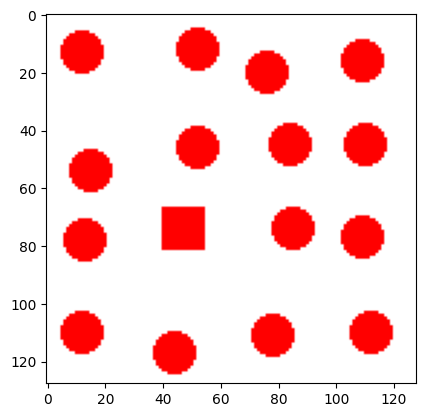

In [ ]:
import matplotlib.pyplot as plt
img, label = generate_visual_search_image(
    n_items=16,
    target_present=True,
    target=target,
    distractors=distractors,
)

plt.imshow(img)

In [ ]:
import pandas as pd
import random
import numpy as np
from PIL import Image, ImageDraw
import os
import random
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
import math

def generate_dataset(out_dir="visual_search", n_samples=125):
    os.makedirs(out_dir, exist_ok=True)
    nested_path = os.path.join(out_dir, "images")
    os.makedirs(nested_path, exist_ok=True)

    metadata = []
    set_sizes = [1,4,8,16]

    #feature search:
    s_type = "feat"
    target = dict(
        type="square",
        color=(255, 0, 0),
    )

    distractors = [
        dict(type="circle", color=(255, 0, 0)),
    ]

    for ss in set_sizes:
      for i in range(n_samples):
          target_present = random.random() < 0.5

          img, label = generate_visual_search_image(
              n_items=ss,
              target_present=target_present,
              target=target,
              distractors=distractors,
          )

          file_directory = f"{out_dir}/images/img_{i:04d}_{ss}_{s_type}.png"
          filename = f"img_{i:04d}_{ss}_{s_type}.png"
          img.save(file_directory, "PNG")

          metadata.append({
              "filename": filename,
              "label": label,
              "set_size": ss,
              "search_type": "feature",
          })

    #metadata csv
    df = pd.DataFrame(metadata)
    df.to_csv(f"{out_dir}/metadata.csv", index=False)

    return df

In [ ]:
df = generate_dataset(n_samples=1000)

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

class VisualSearchDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, one_hot=False):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.one_hot = one_hot

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row.filename)

        img = Image.open(img_path).convert("L")

        if self.one_hot:
            label = torch.nn.functional.one_hot(
                torch.tensor(label),
                num_classes=2
            ).float()

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(row.label, dtype=torch.long)
        return img, label


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df.label,
    random_state=42, shuffle=True
)


In [ ]:
from torchvision import transforms
batch_size=32
from torch.utils.data import TensorDataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_data = VisualSearchDataset(
    train_df,
    img_dir="/content/visual_search/images",
    transform=transform
)
test_data = VisualSearchDataset(
    test_df,
    img_dir="/content/visual_search/images",
    transform=transform
)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [ ]:
def train_one_epoch(model, criterion, accuracy_fn, optimizer, training_loader, epoch_index, batch_print=1000):
    model = model.to(DEVICE)
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting

    correct = 0 # Count number of correct labels, assuming a classification task.
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        correct += accuracy_fn(outputs, labels).item()

        # Gather data and report
        running_loss += loss.item()
        if i % batch_print == batch_print-1:
            last_loss = running_loss / 1000 # loss per batch
            print(f'  batch {i + 1} loss: {last_loss:.3e}')
            running_loss = 0.

    return last_loss, correct / len(training_loader.dataset)

In [ ]:
from datetime import datetime

def train_model(model, criterion, accuracy_fn, optimizer, training_loader, validation_loader=None,
                num_epochs=5, batch_print=1000, eval_funcs=None, model_logging=False):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    best_vloss = 1_000_000.


    training_loss = []
    validation_loss = []

    training_accuracy = []
    validation_accuracy = []

    model = model.to(DEVICE)

    for epoch in range(num_epochs):
        print(f'EPOCH {epoch + 1}:')

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True) # <- Note, we are putting the model back in training mode.
        avg_loss, accuracy = train_one_epoch(model, criterion, accuracy_fn, optimizer, training_loader, epoch, batch_print=batch_print)


        training_loss.append(avg_loss)
        training_accuracy.append(accuracy)
        running_vloss = 0.0


        if validation_loader is None:
            # No validation data, skip evaluation
            continue

        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        val_correct = 0
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                vinputs = vinputs.to(DEVICE)
                vlabels = vlabels.to(DEVICE)
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()

                val_correct += accuracy_fn(voutputs, vlabels).item()
                #(voutputs.argmax(dim=1)==vlabels.argmax(dim=1)).float().sum()

        avg_vloss = running_vloss / (i + 1)
        val_acc = val_correct / len(validation_loader.dataset)

        validation_loss.append(avg_vloss)
        validation_accuracy.append(val_acc)
        print(f'LOSS train {avg_loss:.3e} valid {avg_vloss:.3e}, train acc {accuracy:.2f}, val acc {val_acc:.2f}')

        # Track best performance, and save the model's state
        if model_logging and avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = 'model_{}_{}'.format(timestamp, epoch)
            torch.save(model.state_dict(), model_path)

    return {
        'loss':training_loss,
        'val_loss':validation_loss,
        'accuracy':training_accuracy,
        'val_accuracy':validation_accuracy,
           }

In [ ]:

def cross_entropy_accuracy(y_pred, y_true):
    '''
    We need to change the accuracy function because the output is a vector encoding a distribution
    over the categories, but the true label is just the class number.
    '''
    return (y_pred.argmax(dim=1) == y_true).float().sum()

In [ ]:
import torch.nn as nn

def make_cnn_model():
    model = nn.Sequential(
        # Input: (1, 128, 128) — grayscale image
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),   # (8, 64, 64)

        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),   # (16, 32, 32)

        # Reduce spatial size in a principled way
        nn.AdaptiveAvgPool2d((4, 4)),  # (16, 4, 4)

        nn.Flatten(),
        nn.Linear(16 * 4 * 4, 64),
        nn.ReLU(),

        nn.Linear(64, 2)  # target absent / present
    )
    return model

cnN_model = make_cnn_model()


In [ ]:
import torch.optim as optim

In [ ]:
import torch.optim as optim
optimizer = optim.Adam(cnN_model.parameters())
criterion = nn.CrossEntropyLoss()
history = train_model(
    cnN_model,
    criterion,
    cross_entropy_accuracy,
    optimizer,
    train_loader,
    test_loader,
    num_epochs=10,
    batch_print=100,
)

EPOCH 1:
  batch 100 loss: 6.938e-02
LOSS train 6.938e-02 valid 6.933e-01, train acc 0.51, val acc 0.50
EPOCH 2:
  batch 100 loss: 6.935e-02
LOSS train 6.935e-02 valid 6.932e-01, train acc 0.50, val acc 0.50
EPOCH 3:
  batch 100 loss: 6.932e-02
LOSS train 6.932e-02 valid 6.931e-01, train acc 0.50, val acc 0.50
EPOCH 4:
  batch 100 loss: 6.932e-02
LOSS train 6.932e-02 valid 6.930e-01, train acc 0.51, val acc 0.50
EPOCH 5:
  batch 100 loss: 6.925e-02
LOSS train 6.925e-02 valid 6.907e-01, train acc 0.54, val acc 0.67
EPOCH 6:
  batch 100 loss: 6.759e-02
LOSS train 6.759e-02 valid 6.351e-01, train acc 0.70, val acc 0.84
EPOCH 7:
  batch 100 loss: 4.913e-02
LOSS train 4.913e-02 valid 2.636e-01, train acc 0.86, val acc 0.99
EPOCH 8:
  batch 100 loss: 1.032e-02
LOSS train 1.032e-02 valid 3.114e-02, train acc 0.99, val acc 1.00
EPOCH 9:
  batch 100 loss: 1.615e-03
LOSS train 1.615e-03 valid 8.342e-03, train acc 1.00, val acc 1.00
EPOCH 10:
  batch 100 loss: 5.709e-04
LOSS train 5.709e-04 valid

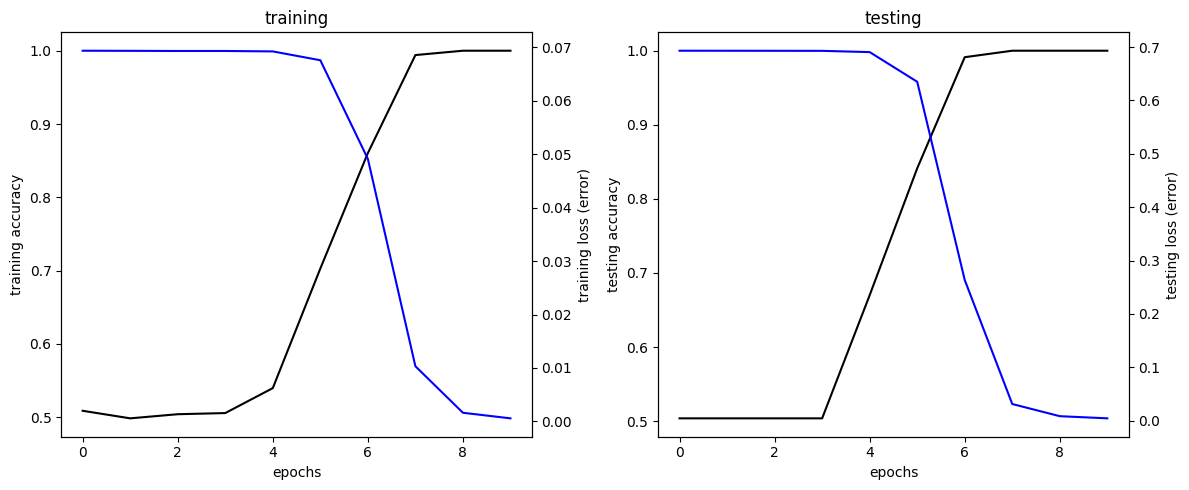

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

In [ ]:
import torch.nn as nn

def make_cnn_model(k):
    model = nn.Sequential(
        # Input: (1, 128, 128) — grayscale image
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=k, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),   # (8, 64, 64)

        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=k, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),   # (16, 32, 32)

        # Reduce spatial size in a principled way
        nn.AdaptiveAvgPool2d((4, 4)),  # (16, 4, 4)

        nn.Flatten(),
        nn.Linear(16 * 4 * 4, 64),
        nn.ReLU(),

        nn.Linear(64, 2)  # target absent / present
    )
    return model

#cnN_model = make_cnn_model()

In [ ]:
k_sizes = [3,5,7,9,11]
train_acc_lst = []
test_acc_lst = []

for k in k_sizes:
  tr_acc_lst = []
  #train_err_lst = []
  te_acc_lst = []
  #test_err_lst = []
  for i in range(10):
    cnn_model = make_cnn_model(k)
    optimizer = optim.Adam(cnn_model.parameters())
    criterion = nn.CrossEntropyLoss()
    history = train_model(
        cnn_model,
        criterion,
        cross_entropy_accuracy,
        optimizer,
        train_loader,
        test_loader,
        num_epochs=10,
        batch_print=100,
    )

    train_acc = history['accuracy'][-1]
    #train_err = history['loss'][-1]
    test_acc = history['val_accuracy'][-1]
    #test_err = history['val_loss'][-1]

    tr_acc_lst.append(train_acc)
    #train_err_lst.append(train_err)
    te_acc_lst.append(test_acc)
    #test_err_lst.append(test_err)

  train_acc_lst.append(tr_acc_lst)
  test_acc_lst.append(te_acc_lst)

train_acc_array = np.array(train_acc_lst)
#train_err_array = np.array(train_err_lst)
test_acc_array = np.array(test_acc_lst)
#test_err_array = np.array(test_err_lst)

EPOCH 1:
  batch 100 loss: 6.946e-02
LOSS train 6.946e-02 valid 6.931e-01, train acc 0.51, val acc 0.50
EPOCH 2:
  batch 100 loss: 6.934e-02
LOSS train 6.934e-02 valid 6.931e-01, train acc 0.49, val acc 0.50
EPOCH 3:
  batch 100 loss: 6.937e-02
LOSS train 6.937e-02 valid 6.933e-01, train acc 0.50, val acc 0.50
EPOCH 4:
  batch 100 loss: 6.934e-02
LOSS train 6.934e-02 valid 6.930e-01, train acc 0.49, val acc 0.50
EPOCH 5:
  batch 100 loss: 6.937e-02
LOSS train 6.937e-02 valid 6.930e-01, train acc 0.50, val acc 0.50
EPOCH 6:
  batch 100 loss: 6.935e-02
LOSS train 6.935e-02 valid 6.930e-01, train acc 0.50, val acc 0.50
EPOCH 7:
  batch 100 loss: 6.939e-02
LOSS train 6.939e-02 valid 6.942e-01, train acc 0.50, val acc 0.50
EPOCH 8:
  batch 100 loss: 6.935e-02
LOSS train 6.935e-02 valid 6.931e-01, train acc 0.49, val acc 0.50
EPOCH 9:
  batch 100 loss: 6.934e-02
LOSS train 6.934e-02 valid 6.931e-01, train acc 0.50, val acc 0.50
EPOCH 10:
  batch 100 loss: 6.935e-02
LOSS train 6.935e-02 valid

In [ ]:
ci_low_tracc_lst = []
ci_high_tracc_lst = []

for i in range(len(train_acc_array)):
  acc_by_k = train_acc_array[i]
  ci_low, ci_high = scipy.stats.bootstrap([acc_by_k], np.mean).confidence_interval
  ci_low_tracc_lst.append(ci_low)
  ci_high_tracc_lst.append(ci_high)


ci_low_teacc_lst = []
ci_high_teacc_lst = []

for i in range(len(test_acc_array)):
  acc_by_k = test_acc_array[i]
  ci_low, ci_high = scipy.stats.bootstrap([acc_by_k], np.mean).confidence_interval
  ci_low_teacc_lst.append(ci_low)
  ci_high_teacc_lst.append(ci_high)

In [ ]:
#len(train_acc_array)
ci_high_tracc_lst

[np.float64(0.6499204407310103),
 np.float64(0.9998125),
 np.float64(0.99953125),
 np.float64(0.952875),
 np.float64(0.7995859404518282)]

In [ ]:
ci_low_tracc_lst

[np.float64(0.5534104112352991),
 np.float64(0.764667046437804),
 np.float64(0.70184375),
 np.float64(0.7042017112777046),
 np.float64(0.5179362364234469)]

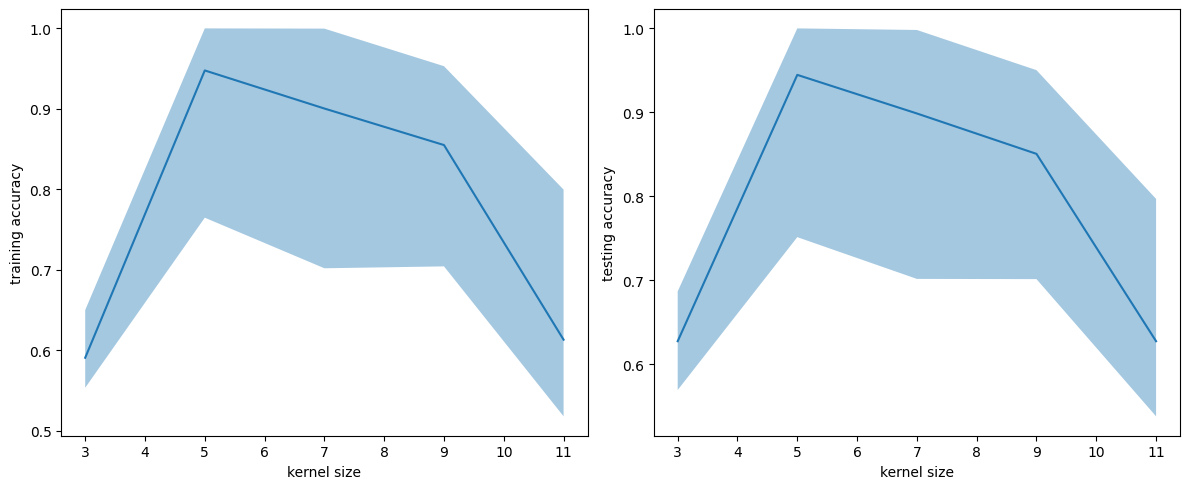

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
mean_tr_acc = []
for i in range(len(train_acc_array)):
  mean_tr_acc.append(np.mean(train_acc_array[i]))
plt.plot(k_sizes, mean_tr_acc)
plt.fill_between(k_sizes, ci_low_tracc_lst, ci_high_tracc_lst, alpha=0.4)
plt.xlabel("kernel size")
plt.ylabel("training accuracy")

plt.subplot(1, 2, 2)
mean_te_acc = []
for i in range(len(test_acc_array)):
  mean_te_acc.append(np.mean(test_acc_array[i]))
plt.plot(k_sizes, mean_te_acc)
plt.fill_between(k_sizes, ci_low_teacc_lst, ci_high_teacc_lst, alpha=0.4)
plt.xlabel("kernel size")
plt.ylabel("testing accuracy")
plt.tight_layout()
plt.show()

In [ ]:
output = cnn_model(test_loader.dataset.tensors[0])

In [ ]:
#output = cnn_model(test_loader.dataset.tensors[0].to(DEVICE))
output = cnn_model(test_loader.dataset.tensors[0].to(DEVICE))
category = output.argmax(dim=1)

plt.imshow(test_loader.dataset.tensors[0][0])
plt.title(f'True label = {test_loader.dataset.tensors[1][0].argmax()}, Predicted = {category[0]}' )
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])

In [ ]:
train_acc_lst = []
train_err_lst = []
test_acc_lst = []
test_err_lst = []
for i in range(10):
  cnn_model = make_cnn_model()
  optimizer = optim.Adam(cnn_model.parameters())
  criterion = nn.CrossEntropyLoss()
  history = train_model(
      cnn_model,
      criterion,
      cross_entropy_accuracy,
      optimizer,
      train_loader,
      test_loader,
      num_epochs=10,
      batch_print=100,
  )

  train_acc = history['accuracy']
  train_err = history['loss']
  test_acc = history['val_accuracy']
  test_err = history['val_loss']

  train_acc_lst.append(train_acc)
  train_err_lst.append(train_err)
  test_acc_lst.append(test_acc)
  test_err_lst.append(test_err)

train_acc_array = np.array(train_acc_lst)
train_err_array = np.array(train_err_lst)
test_acc_array = np.array(test_acc_lst)
test_err_array = np.array(test_err_lst)

EPOCH 1:
  batch 100 loss: 6.938e-02
LOSS train 6.938e-02 valid 6.931e-01, train acc 0.50, val acc 0.50
EPOCH 2:
  batch 100 loss: 6.934e-02
LOSS train 6.934e-02 valid 6.927e-01, train acc 0.51, val acc 0.51
EPOCH 3:
  batch 100 loss: 6.918e-02
LOSS train 6.918e-02 valid 6.891e-01, train acc 0.54, val acc 0.55
EPOCH 4:
  batch 100 loss: 6.749e-02
LOSS train 6.749e-02 valid 6.374e-01, train acc 0.61, val acc 0.74
EPOCH 5:
  batch 100 loss: 5.128e-02
LOSS train 5.128e-02 valid 3.161e-01, train acc 0.81, val acc 0.93
EPOCH 6:
  batch 100 loss: 1.811e-02
LOSS train 1.811e-02 valid 1.430e-01, train acc 0.97, val acc 0.96
EPOCH 7:
  batch 100 loss: 5.519e-03
LOSS train 5.519e-03 valid 2.943e-02, train acc 1.00, val acc 1.00
EPOCH 8:
  batch 100 loss: 1.922e-03
LOSS train 1.922e-03 valid 1.240e-02, train acc 1.00, val acc 1.00
EPOCH 9:
  batch 100 loss: 1.146e-03
LOSS train 1.146e-03 valid 8.126e-03, train acc 1.00, val acc 1.00
EPOCH 10:
  batch 100 loss: 6.287e-04
LOSS train 6.287e-04 valid

In [ ]:
ci_low_tracc_lst = []
ci_high_tracc_lst = []

for i in range(len(train_acc_array.T)):
  acc_by_epoch = train_acc_array.T[i]
  ci_low, ci_high = scipy.stats.bootstrap([acc_by_epoch], np.mean).confidence_interval
  ci_low_tracc_lst.append(ci_low)
  ci_high_tracc_lst.append(ci_high)

ci_low_trerr_lst = []
ci_high_trerr_lst = []

for i in range(len(train_err_array.T)):
  acc_by_epoch = train_err_array.T[i]
  ci_low, ci_high = scipy.stats.bootstrap([acc_by_epoch], np.mean).confidence_interval
  ci_low_trerr_lst.append(ci_low)
  ci_high_trerr_lst.append(ci_high)

ci_low_teacc_lst = []
ci_high_teacc_lst = []

for i in range(len(test_acc_array.T)):
  acc_by_epoch = test_acc_array.T[i]
  ci_low, ci_high = scipy.stats.bootstrap([acc_by_epoch], np.mean).confidence_interval
  ci_low_teacc_lst.append(ci_low)
  ci_high_teacc_lst.append(ci_high)

ci_low_teerr_lst = []
ci_high_teerr_lst = []

for i in range(len(test_err_array.T)):
  acc_by_epoch = test_err_array.T[i]
  ci_low, ci_high = scipy.stats.bootstrap([acc_by_epoch], np.mean).confidence_interval
  ci_low_teerr_lst.append(ci_low)
  ci_high_teerr_lst.append(ci_high)

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
for i in range(len(train_acc_array)):
  plt.plot(train_acc_array[i])
plt.fill_between(range(10), ci_low_tracc_lst, ci_high_tracc_lst, alpha=0.4)
plt.xlabel("epochs")
plt.ylabel("training accuracy")

plt.subplot(1, 2, 2)
for i in range(len(test_acc_array)):
  plt.plot(test_acc_array[i])
plt.fill_between(range(10), ci_low_teacc_lst, ci_high_teacc_lst, alpha=0.4)
plt.xlabel("epochs")
plt.ylabel("testing accuracy")
plt.tight_layout()
plt.show()